In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import StandardScaler
from datetime import timedelta

In [13]:
# Read csv file
df = pd.read_csv('../data/nz.csv')

In [14]:
# An overlook of data
df.head()

,date,people_vaccinated,people_fully_vaccinated,total_vaccinations,vaccine,location,source_url,total_boosters
0,2021-02-19,29,0,29,Pfizer/BioNTech,New Zealand,https://www.health.govt.nz/our-work/diseases-a...,NaN
1,2021-02-20,94,0,94,Pfizer/BioNTech,New Zealand,https://www.health.govt.nz/our-work/diseases-a...,NaN
2,2021-02-21,162,1,163,Pfizer/BioNTech,New Zealand,https://www.health.govt.nz/our-work/diseases-a...,NaN
3,2021-02-22,610,1,611,Pfizer/BioNTech,New Zealand,https://www.health.govt.nz/our-work/diseases-a...,NaN
4,2021-02-23,968,1,969,Pfizer/BioNTech,New Zealand,https://www.health.govt.nz/our-work/diseases-a...,NaN


In [15]:
# Columns
df.columns

Index(['date', 'people_vaccinated', 'people_fully_vaccinated',
       'total_vaccinations', 'vaccine', 'location', 'source_url',
       'total_boosters'],
      dtype='object')

In [16]:
# Drop columns which are not required
df = df.drop(['vaccine', 'location', 'source_url', 'total_boosters', 'people_vaccinated', 'people_fully_vaccinated'], axis=1)

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

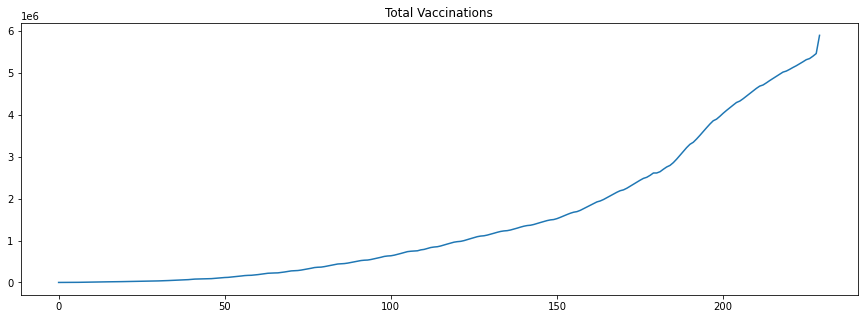

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df['total_vaccinations'])
plt.title("Total Vaccinations")
plt.show()

In [18]:
df.tail(n=6)

,date,total_vaccinations
224,2021-10-01,5270226
225,2021-10-02,5320467
226,2021-10-03,5347565
227,2021-10-04,5403487
228,2021-10-05,5467111
229,2021-10-11,5902104


### Analysis

By looking at the above chart and data, it is clear that there is a sudden spike at the end. Number of vaccinations per day is less than 100,000 constantly and suddenly for the last date in the dataset, it's more than 400,000 a day. 5 days of data also is missing. Is the last value, sum of vaccinations of those 5 days?

From machine learning point of view, it makes perfect sense to remove the spike in the end since it's clearly an outlier. We will explore results for both possibilities. Using original data and removing the outlier at the end.

## 1. Without removing the spike at the end

In [19]:
# Dataset
data = df['total_vaccinations'].values.reshape(-1,1)

In [20]:
# Scaling. We will use standard scaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

### ARIMA model 

In [21]:
# Values for 'order' parameter are selected after hyper parameter tuning. Many values were tried and (25,1,0) gave the best results among them.
model = ARIMA(data, order=(25,1,0))
model = model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### Forecasting

In [22]:
# Number of days in the future to forecast
num_days = 90

In [23]:
# Forecast total vaccinations for next 90 days
results = model.predict(start=data.size, end=data.size+num_days-1, dunamic=True)
results = scaler.inverse_transform(results.reshape(-1, 1))

In [24]:
# Extend the date list for next 90 days
datelist = list(df['date'])

for i in range(num_days):
    datelist.append(datelist[-1] + timedelta(days=1))

### Visualize Results

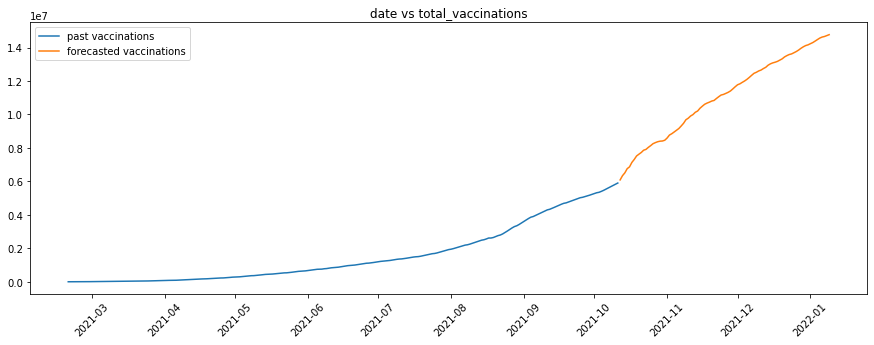

Last value: 14770844.241498504


In [25]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(datelist[:data.size], df['total_vaccinations'], label='past vaccinations')
plt.plot(datelist[data.size:], results, label='forecasted vaccinations')
plt.title("date vs total_vaccinations")
plt.legend()
plt.xticks(rotation=45)
plt.show()

print(f"Last value: {results[-1][0]}")

#### It's clearly visible that model has picked up the spike in the end and forecasts have much upward trend. Total vaccinations are projected to reach 14.7 million in next 3 months.

## 2. Removing spike at the end

In [26]:
# Create a new column containing smoothed version of the data. 
df['vaccinations_smoothed'] = df['total_vaccinations'].rolling(window=3).mean()

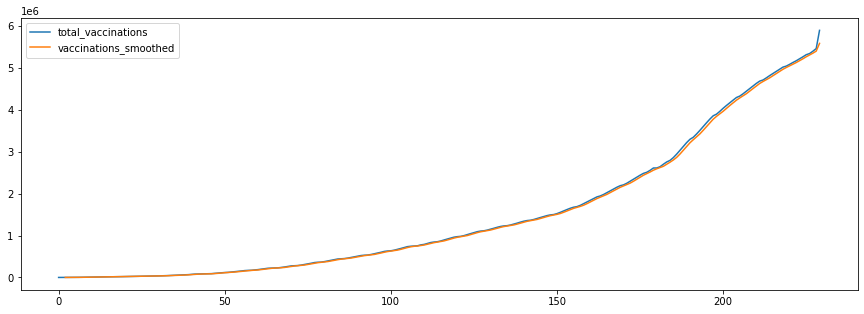

In [27]:
plt.plot(df['total_vaccinations'], label='total_vaccinations')
plt.plot(df['vaccinations_smoothed'], label='vaccinations_smoothed')
plt.legend()
plt.show()

#### Looking at the orange curve, in the very end, we can see that the spike is somewhat removed

We will be using the smoothed version to train our model 

In [28]:
# Create Dataset and scale it
data = df['vaccinations_smoothed'].values.reshape(-1,1)

scaler = StandardScaler()
data = scaler.fit_transform(data)

### ARIMA model

In [29]:
model = ARIMA(data, order=(25,1,0))
model = model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### Forecasting

In [30]:
# Number of days in the future to forecast
num_days = 90

In [31]:
# Forecast total vaccinations for next 90 days
results = model.predict(start=data.size, end=data.size+num_days-1, dunamic=True)
results = scaler.inverse_transform(results.reshape(-1, 1))

In [32]:
# Extend the date list for next 90 days

datelist = list(df['date'])

for i in range(num_days):
    datelist.append(datelist[-1] + timedelta(days=1))

### Visualize Results

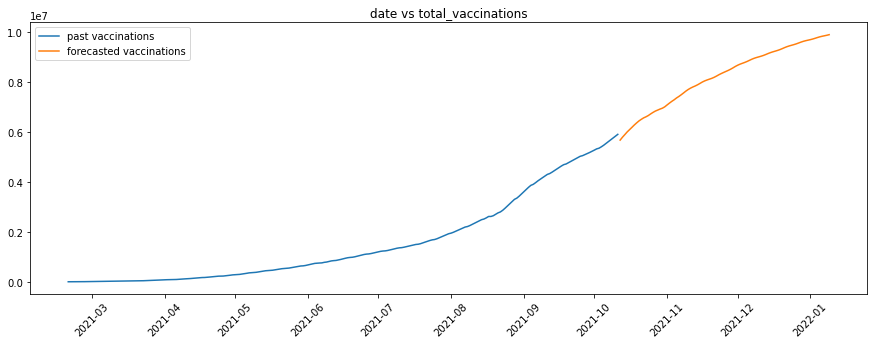

Last value: 9893336.100654649


In [33]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(datelist[:data.size], df['total_vaccinations'], label='past vaccinations')
plt.plot(datelist[data.size:], results, label='forecasted vaccinations')
plt.title("date vs total_vaccinations")
plt.legend()
plt.xticks(rotation=45)
plt.show()

print(f"Last value: {results[-1][0]}")

#### Now that the spike is removed, forecasts have less upward trend. Total vaccinations are projected to reach 9.8 million in next 3 months.